### Student Information
Name: 黃玄彰

Student ID: 110030031

GitHub ID: pigerface@gmail.com

Kaggle name: pigerface

Kaggle private scoreboard snapshot:



<img src="img\pic0.png" />

# 1. Take Home Exercise

---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


/tmp/ipykernel_2409142/2572367273.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_top_30_words.values, y=train_top_30_words.index,


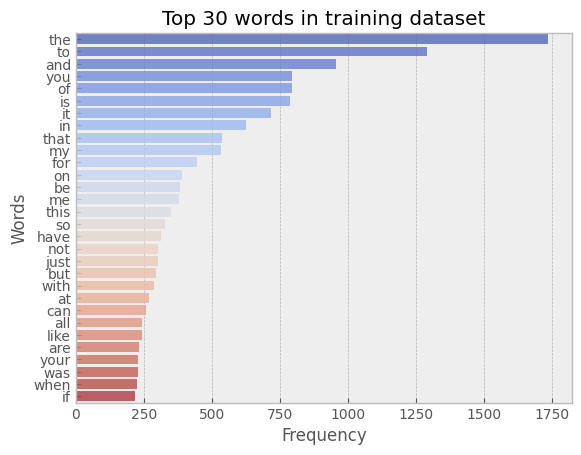

/tmp/ipykernel_2409142/2572367273.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_top_30_words.values, y=test_top_30_words.index,


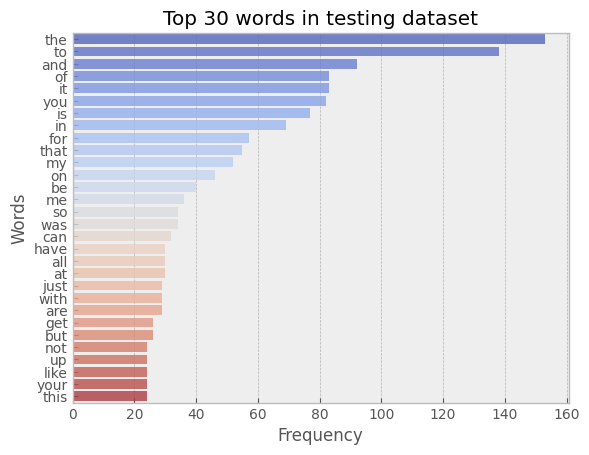

In [ ]:
# Answer here
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# Use CountVectorizer to get the frequency of the words in the training dataset
train_count_vect = CountVectorizer()
train_counts = train_count_vect.fit_transform(train_df['text'])
train_term_freq = train_counts.sum(axis=0).A1
train_term_freq = pd.Series(train_term_freq, index=train_count_vect.get_feature_names_out())
train_top_30_words = train_term_freq.sort_values(ascending=False).head(30)
train_top_30_words

# Plot
sns.barplot(x=train_top_30_words.values, y=train_top_30_words.index,
            palette='coolwarm',
            alpha=0.8) 
plt.style.use("bmh")
plt.title('Top 30 words in training dataset')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Use CountVectorizer to get the frequency of the words in the testing dataset
test_count_vect = CountVectorizer()
test_counts = test_count_vect.fit_transform(test_df['text'])
test_term_freq = test_counts.sum(axis=0).A1
test_term_freq = pd.Series(test_term_freq, index=test_count_vect.get_feature_names_out())
test_top_30_words = test_term_freq.sort_values(ascending=False).head(30)
test_top_30_words

# Plot
sns.barplot(x=test_top_30_words.values, y=test_top_30_words.index,
            palette='coolwarm',
            alpha=0.8) 
plt.style.use("bmh")
plt.title('Top 30 words in testing dataset')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()



---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [ ]:
# Answer here
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(train_df['text'])
print(f'feature names for features [100:110]: {tfidf_vectorizer.get_feature_names_out()[100:110]}')

feature names for features [100:110]: ['bitter' 'black' 'blacks' 'blame' 'blessed' 'blood' 'bloody' 'blues'
 'body' 'boiling']


---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

In [ ]:
# Answer here

# From the confusion matrix, we can see the value on the diagonal are all high
# , which means the model do have the ability to classify the data. And the values 
# are correlated with their frequency in the dataset.
# However, we can some value outside the diagonal has the relatively high value,
# for example, the value of fear and anger is high, we can assume that the model
# is not good at distinguishing between fear and anger. It makes sense because
# fear and anger may have similar expressions. And we can also see the value of
# predict fear and true sadness is also high, but predict sadness and true fear is
# low. It means the model tends to predict fear when the true label is sadness but
# not the other way around.



---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

training accuracy: 0.79
testing accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

       anger     0.6322    0.6548    0.6433        84
        fear     0.7328    0.7727    0.7522       110
         joy     0.7778    0.7089    0.7417        79
     sadness     0.6389    0.6216    0.6301        74

    accuracy                         0.6974       347
   macro avg     0.6954    0.6895    0.6918       347
weighted avg     0.6986    0.6974    0.6974       347



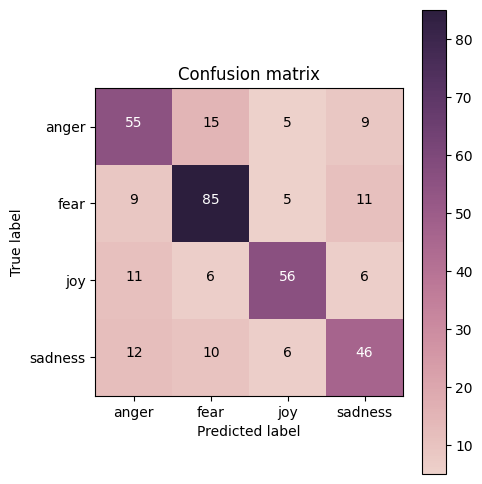

In [ ]:
# Answer here
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
nb_y_train_pred = nb_classifier.predict(X_train)
nb_y_test_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
acc_train = accuracy_score(y_true=y_train, y_pred=nb_y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=nb_y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))
print("\nClassification Report:\n", classification_report(y_test, nb_y_test_pred, target_names=my_tags, digits=4))
cm_nb = confusion_matrix(y_test, nb_y_test_pred)
plot_confusion_matrix(cm_nb, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

In [ ]:
# Answer here
# From the result, we can see that the accuracy of the Naive Bayes model is higher than the Decision Tree model.
# I think the reason is that the decision tree model is based on rule-based splitting, and it is more likely to
# suffer from the problem of overfitting when facing the data with high dimensionality.
# While the Naive Bayes model is good at handling the high-dimensional and sparse data.
# Besides, the Naive Bayes also assume the independence of the features, which works well in text classification
# since there are many words that have directly relationship with the emotion, for example, "happy" is often
# related to the joy emotion so it is easy for naive bayes to classify the data.


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?

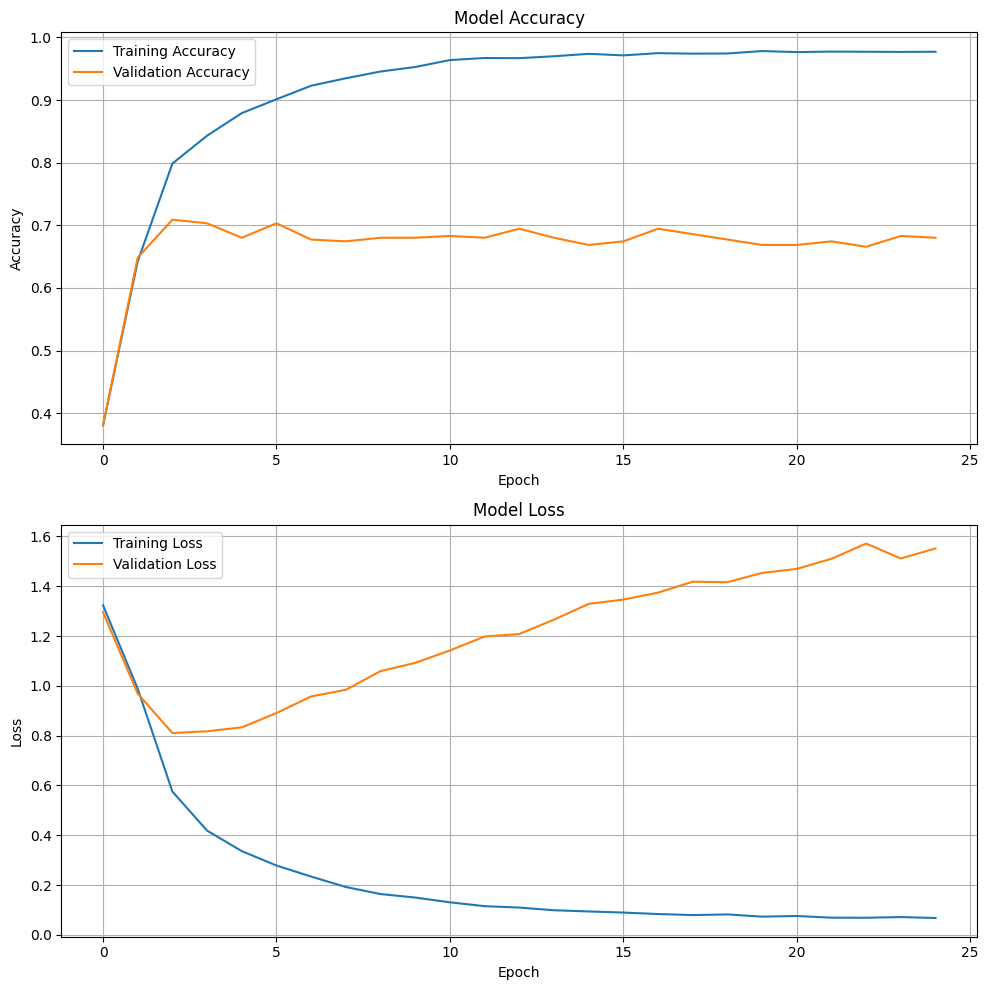

In [ ]:
# Answer here
# Load training log
training_log = pd.read_csv("logs/training_log.csv")

# Create a 2x1 subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot accuracy graph
ax1.plot(training_log['epoch'], training_log['accuracy'], label='Training Accuracy')
ax1.plot(training_log['epoch'], training_log['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss graph
ax2.plot(training_log['epoch'], training_log['loss'], label='Training Loss')
ax2.plot(training_log['epoch'], training_log['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# From the graph, we can see that the accuracy of the model is increasing as the epoch increases,
# which means the model is learning from the data.
# However, the validation accuracy doesn't increase as the training accuracy, which means the model
# is not performing well on the validation data, which is a sign of overfitting.
# We can also see the same phenomenon in the loss graph.
# The training loss is decreasing as the epoch increases, but the validation loss is not.
# This also means the model is overfitting to the training data so it performs well on the training data
# but not well on the validation data.

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


In [ ]:
# Answer here

# We can use the tf-idf to calculate the weighted sum of the word vectors of the sentence to represent the sentence.

from sklearn.feature_extraction.text import TfidfVectorizer

def get_weighted_sentence_vector(sentences, model=w2v_google_model):
    # Create TF-IDF model
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(sentences)
    
    # Get vocabulary and weights
    vocabulary = tfidf.get_feature_names_out()
    
    # Calculate weighted vectors
    weighted_vectors = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence.lower())
        sentence_vector = np.zeros(model.vector_size)
        word_count = 0
        
        for word in words:
            try:
                # Get word vector
                word_vector = model[word]
                # Get TF-IDF weight
                if word in vocabulary:
                    weight = tfidf_matrix[0, tfidf.vocabulary_[word]]
                    sentence_vector += word_vector * weight
                    word_count += 1
            except KeyError:
                continue
                
        if word_count > 0:
            sentence_vector /= word_count
        weighted_vectors.append(sentence_vector)
        
    return np.array(weighted_vectors)

# Convert text to list
sentences = train_df['text'].to_list()
# Using TF-IDF weighting
print("\nTF-IDF weighted method:")
weighted_vectors = get_weighted_sentence_vector(sentences)
for i, sentence in enumerate(sentences):
    print(f"Sentence: {sentence}")
    print(f"Vector dimension: {weighted_vectors[i].shape}")
    # print the first 5 elements of the vector
    print(f"Vector(first 5 elements): {weighted_vectors[i][:5]}")
    print("---")


TF-IDF weighted method:
Sentence: @LonelyGoomba I wouldn't bring this up if I were you. It's a very touchy subject. And people get way to offended these days
Vector dimension: (300,)
Vector(first 5 elements): [ 0.01967048  0.00785923  0.01143813  0.02078413 -0.0282086 ]
---
Sentence: Be happy not because everything is good, but because you can see the good side of everything  #optimism
Vector dimension: (300,)
Vector(first 5 elements): [ 1.39394961e-03  9.00398077e-05  5.16895205e-04  1.94752764e-03
 -7.43662117e-04]
---
Sentence: Val is the type of woman you would dread bringing a donation for the bake sale #GBBO
Vector dimension: (300,)
Vector(first 5 elements): [ 0.00169265  0.00010933  0.00062766  0.00236485 -0.00090302]
---
Sentence: Gotta hit up breezy every day to make sure he's breaking in my boots. First class friend right there
Vector dimension: (300,)
Vector(first 5 elements): [ 0.00112623 -0.00018885  0.00194115  0.0013643  -0.00203271]
---
Sentence: @snowangel415 @cjwalte

---


### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE and UMAP visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total). Compare the differences between both graphs.

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirsc

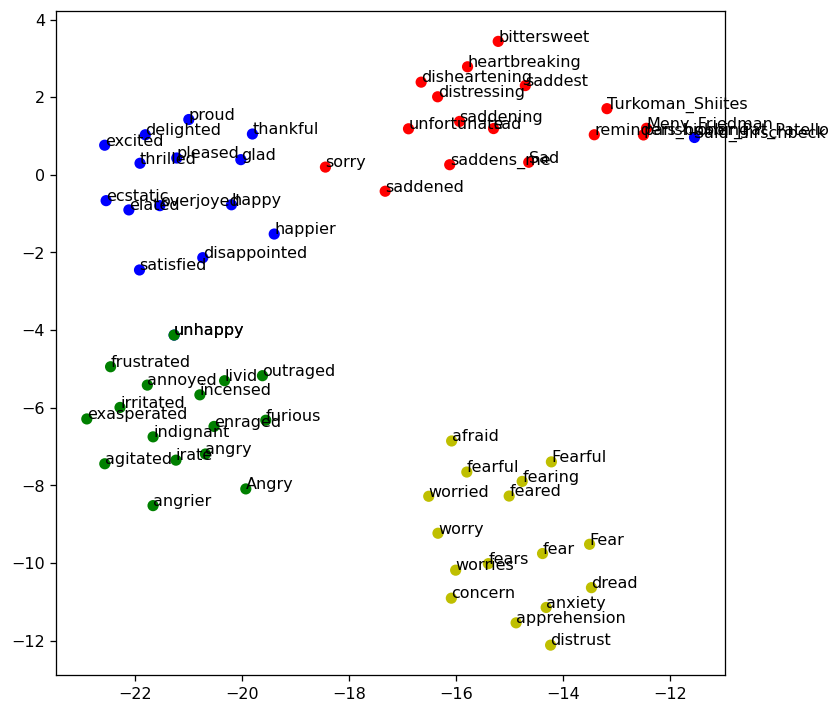

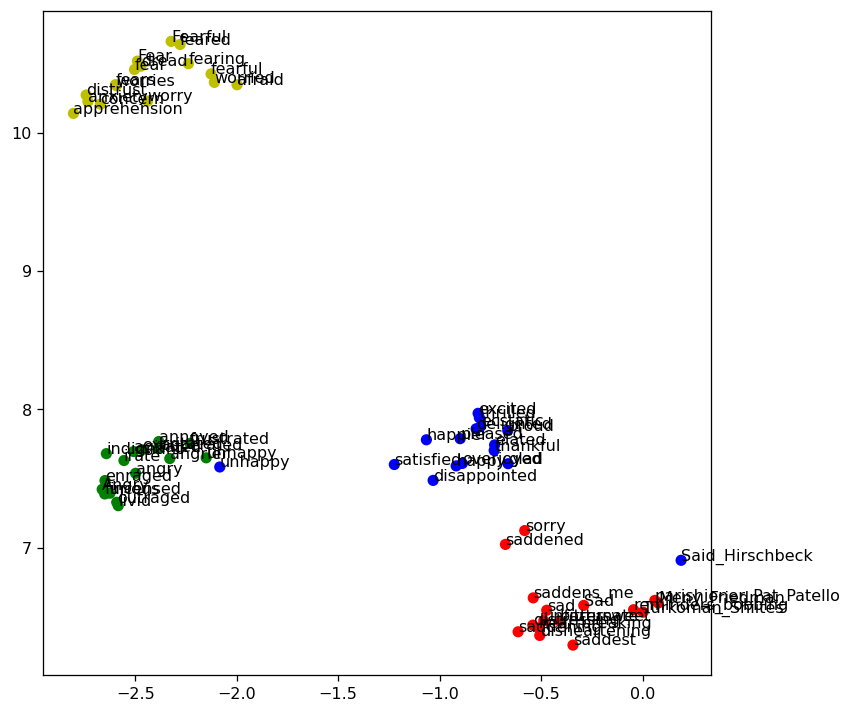

In [ ]:
# Answer here
word_list = ['happy', 'angry', 'data', 'mining']

topn = 15
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = happy_words + angry_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

###### t-SNE ######
## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

###### UMAP ######
## UMAP model
umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=28)

## training
X_umap = umap_model.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_umap[:target_size, 0], X_umap[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_umap[:target_size, 0], X_umap[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

## Observation and Comparison
# From the t-SNE and UMAP visualization, we can see that the words are more compact in UMAP than t-SNE.
# It is because that UMAP have a better ability to preserve the global structure of the data (relative distance between clusters) than t-SNE.
# But t-SNE is better at preserving the local structure of the data (relationships between similar points) so we can see the word "unhappy" 
# is closer to its cluster than UMAP.
# We can also observe that the term "Said_Hirschbeck" (the meaning of which remains unclear even after a Google search) 
# is positioned far from its cluster in both the t-SNE and UMAP visualizations.


---


### ** >>> Exercise 9 (Take home): **  

You noticed there is a **role** parameter inside the ollama.chat function, investigate what other roles there can be inside the function and what do they do. Give an example of a prompt using another role in additional to the **user** one.

In [ ]:
# Answer here

# There are three roles: user, assistant, and system.
# The user role is used to send the prompt to the model.
# The assistant role is used to send the response from the model to the user.
# The system role is used to send the system prompt to the model.

# An example of a prompt using the system role is:
response =  ollama.chat(model='llama3.2', 
                        messages=[
                            {'role': 'system', 'content': 'You are a professional data scientist specializing in data mining research. \
                                Please answer questions in a simple and easy to understand way (in markdown format)'}, 
                            {'role': 'user', 'content': 'What is data mining?'}])

display(Markdown(response['message']['content']))

**What is Data Mining?**
==========================

Data mining is the process of automatically discovering patterns, relationships, and insights from large datasets. It involves using various statistical and mathematical techniques to analyze and extract valuable information from raw data.

### Key Characteristics:

* **Automatic**: Data mining uses algorithms and rules to discover patterns and insights without human intervention.
* **Large Datasets**: Data mining often deals with huge amounts of data, including structured, semi-structured, and unstructured data.
* **Pattern Discovery**: The goal is to identify hidden patterns, relationships, and correlations within the data.

### Types of Data Mining:

1. **Supervised Learning**: Predicting outcomes based on labeled data (e.g., classification, regression).
2. **Unsupervised Learning**: Discovering patterns without labeled data (e.g., clustering, dimensionality reduction).

Data mining has numerous applications in various fields, including business, healthcare, finance, and more.

Would you like to know more about the process or types of data mining?

---


### ** >>> Exercise 10 (Take home): **  

Try asking the model with one image of your choosing. Is the description accurate? Why?

In [ ]:
# Answer here
response4 = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': ['./pics/pic5.png'] # Image about before k-means clustering and after k-means clustering
    },
])

display(Markdown(response4['message']['content']))

# I think the description is accurate, because the model is able to understand
# the causality between the before and after k-means clustering.
# and also provide a detailed description of the reasoning process.


The image presents a comparative study of two sets of circles, each labeled with the term "K Means". The first set, located on the left side of the image, consists of black and gray circles arranged in a grid-like pattern. Each circle varies in size and position, creating a sense of randomness. 

On the right side of the image, there's another set of "K Means" labeled circles. These circles are white with red dots on them, suggesting they might be used for clustering or categorization purposes. The arrangement of these circles is more orderly compared to the first set.

The term "Before K Means" is written above the left set of circles, indicating that this could be a pre-clustering scenario. Similarly, the term "After K Means" is written below the right set of circles, implying that these could represent the result after applying the K Means clustering algorithm.

The image seems to visualize the concept and application of the K Means clustering algorithm in data analysis or machine learning contexts. The difference between the two sets of circles might symbolize how raw data (before) can be transformed into meaningful clusters (after) using this algorithm.

---


### ** >>> Exercise 11 (Take home): **  

Try to modify the code to make it accept **three URLs**, or **three text documents** of your choosing. After modifying it, make **three prompts/questions** with information that can be found in each of the documents/urls, **compare the accuracy of the response** with the actual answer. Investigate and discuss the advantages and disadvantages of RAG systems.

In [ ]:
# Answer here
import ollama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

llm_model = "llama3.2"  # You can change this to the preferred model

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(urls):
    all_splits = []
    for url in urls:
        loader = WebBaseLoader(
            web_paths=(url,),
            bs_kwargs=dict()
        )
        docs = loader.load()  # Load data from each URL
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        splits = text_splitter.split_documents(docs)
        all_splits.extend(splits)  # Combine chunks from all URLs
    embeddings = OllamaEmbeddings(model=llm_model)
    vectorstore = Chroma.from_documents(documents=all_splits, embedding=embeddings)
    return vectorstore.as_retriever()

# URLs related to baseball
urls = [
    "https://www.mlb.com/news",
    "https://en.wikipedia.org/wiki/Baseball",
    "https://www.baseball-reference.com"
]

# Create the retriever
retriever = load_and_retrieve_docs(urls)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model=llm_model, messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context)

# Test with three questions
questions = [
        "How many players are necessary for a baseball team?",
        "What is the headline of the news article written by Anthony Castrovince?",
        "How many runs did the Los Angeles Dodgers score in Game 5 on October 30, 2024?"
]

# actual_answers = [
#     "At least 9 players are necessary for a baseball team.",
#     "5 Black Friday blockbuster trades that need to happen",
#     "The Los Angeles Dodgers scored 7 runs in Game 5 on October 30, 2024."
# ]

# Get results
results = [rag_chain(question) for question in questions]

# Results 
print(f'##########################')
print(f'RAG Retrieval Results: {results}')

print(f'##########################')
for i, question in enumerate(questions):
    print(f"### Question {i+1}: {question}")
    print(results[i])
    print("\n")
    
# I believe the accuracy of the response is not very high because the model was only able to 
# answer the first question correctly. From the output of the RAG chain, it is evident that 
# the retriever failed to fetch the correct information from the web. This seems to be the 
# primary reason why the model was unable to answer the other two questions accurately.

# That said, even though the model couldn't provide correct answers to the other two questions, 
# the RAG implementation ensured that the response indicated the unavailability of the requested 
# information on the web, rather than fabricating false answers. This demonstrates that RAG is 
# an effective method for ensuring that the model's responses are grounded in reliable, existing 
# information.

# However, it is worth noting that RAG retrieval does take some time to process and retrieve 
# the necessary information.


##########################
RAG Retrieval Results: ['The text does not provide a specific number for how many players are necessary for a baseball team. However, it does mention that teams have:\n\n* 9 offensive regulars (including the DH)\n* 5 starting pitchers\n* 7 or 8 relievers\n* A backup catcher\n* 2 or 3 other reserve players\n\nThis suggests that a typical team has around 25-30 players, but this number can vary depending on the specific league and organization.', 'There is no headline written by Anthony Castrovince in this text. The text appears to be a passage from an encyclopedia or Wikipedia article, discussing various topics such as music, comedy routines, and baseball regulations, but it does not contain any headlines or articles attributed to Anthony Castrovince.', 'There is no information about Game 5 on October 30, 2024, or any runs scored by the Los Angeles Dodgers in that game. The text appears to be unrelated to a specific baseball game and seems to provide general in

---

### ** >>> Exercise 12 (Take home): **

Follow Exercise 6 again and Plot the Training and Validation Accuracy and Loss for the results of this Neural Network. Compare the results of both KNN and the NN we just implemented. Discuss about why we obtained these results with the LLM Embeddings compared to the results of the other models implemented in this Lab.

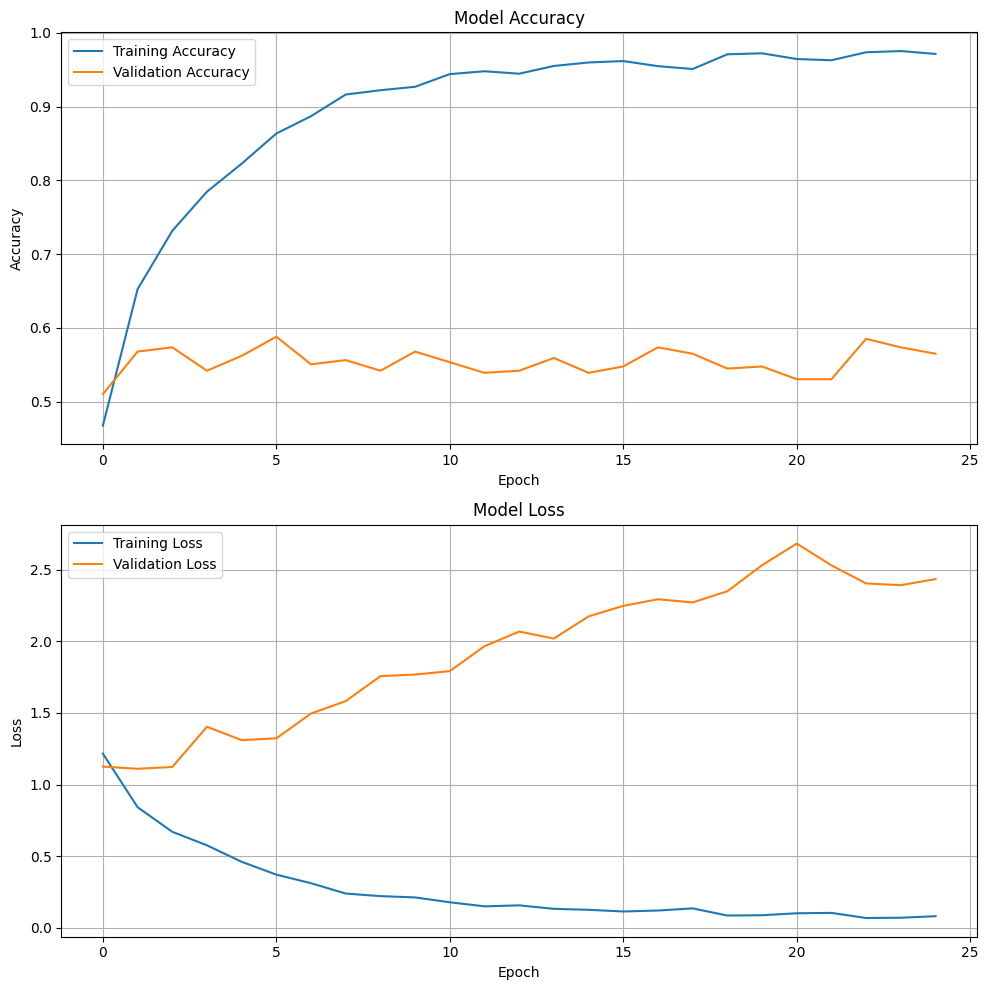

In [ ]:
# Answer here
# Load training log
training_log = pd.read_csv("logs/training_log_2.csv")

# Create a 2x1 subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot accuracy graph
ax1.plot(training_log['epoch'], training_log['accuracy'], label='Training Accuracy')
ax1.plot(training_log['epoch'], training_log['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss graph
ax2.plot(training_log['epoch'], training_log['loss'], label='Training Loss')
ax2.plot(training_log['epoch'], training_log['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Comparison and discussion:
# The accuracy of KNN is lower than the NN model and both of the two model have 
# lower accuracy than the other models we have implemented in the lab.
# I think the reason is that the dimension of the embeddings is too high, which leads to
# the model being too complex and overfitting the training data.
# We can observe that from the training log, the training accuracy is as low as the 
# other models, but the validation accuracy is much higher, it shows that the model has 
# more serious problem with overfitting.



---

### ** >>> Exercise 13 (Take home): **

Compare and discuss the results of the zero-shot, 1-shot and 5-shot classification.

In [ ]:
# Answer here

# From the results, we can see that the accuracy of the zero-shot is the lowest, and the 
# accuracy of the 5-shot is the highest. The 1-shot is in the middle.
# I think the reason is that the zero-shot has no examples to guide the model, so the model
# has to rely on the prompt to understand the task and classify the text, which is not as 
# good as the 1-shot and 5-shot. The 1-shot and 5-shot has more examples to guide the model, 
# so the model can learn the task better and classify the text more accurately.

# However, all of the three models perform awfully bad than the other models we have 
# implemented in the lab. We can observe many misclassifications in the confusion 
# matrix, even the diagonal elements are not the largest values. It shows that the model 
# has a hard time distinguishing the emotions.


---

# 2. Model Developing Report


## 2.1 Import Libraries

In [1]:
import json
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
import emoji
from transformers import TrainingArguments, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments
import os

2024-12-07 03:36:11.855987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 03:36:12.274469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733513772.443257   10048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733513772.492846   10048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 03:36:12.901112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 2.2 Data Loading and Preprocessing

### 2.2.1 Load Data from Files

In [2]:
def load_data(emotion_path, data_identification_path, tweets_path):
    """
    Function to load and process data
    :param emotion_path: str, path to emotion.csv file
    :param data_identification_path: str, path to data_identification.csv file 
    :param tweets_path: str, path to tweets_DM.json file
    :return: pd.DataFrame, pd.DataFrame, pd.DataFrame
    """
    # Read emotion and data_identification data
    emotion = pd.read_csv(emotion_path)
    data_identification = pd.read_csv(data_identification_path)

    # Read tweets_DM.json and parse into DataFrame
    with open(tweets_path, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    _source = df['_source'].apply(lambda x: x['tweet'])
    df = pd.DataFrame({
        'tweet_id': _source.apply(lambda x: x['tweet_id']),
        'hashtags': _source.apply(lambda x: x['hashtags']), 
        'text': _source.apply(lambda x: x['text']),
    })
    
    # Merge with data_identification
    df = df.merge(data_identification, on='tweet_id', how='left')

    return df, emotion, data_identification

### 2.2.2 Clean Text 
(I didn't use this function in the final version since it's performed better without cleaning)

In [3]:
def clean_text(text):
    """
    Helper function to clean text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Convert emojis to text descriptions
    text = emoji.demojize(text)
    
    # Remove special characters but keep emoji descriptions (text between colons)
    text = re.sub(r'[^\w\s:_-]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

### 2.2.3 Preprocess Data


* Use tokenizer (in this case, I use roberta-base) to tokenize the text

* Split the data into train and test sets
* Use label encoder (in this case, I use sklearn.preprocessing.LabelEncoder) to encode the labels

In [4]:
def preprocess_data(df, emotion, label_encoder, tokenizer, clean_func=clean_text):
    """
    Process data, split into train/test sets, and perform tokenization
    """
    # Tokenization function
    def tokenize_function(text):
        return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

    # Split datasets
    train_data = df[df['identification'] == 'train']
    test_data = df[df['identification'] == 'test']
    
    # # Clean text before splitting datasets
    # (I didn't use this function in the final version since it's performed better without cleaning)
    # train_data['text'] = train_data['text'].apply(clean_func)
    # test_data['text'] = test_data['text'].apply(clean_func)

    # Merge emotion with training set
    train_data = train_data.merge(emotion, on='tweet_id', how='left')
    train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['emotion'], test_size=0.2, random_state=42, stratify=train_data['emotion']
    )

    # Reset index
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    
    # Label Encoding
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    
    # Tokenize train and validation sets
    X_train_tokenized = X_train.apply(tokenize_function)
    X_val_tokenized = X_val.apply(tokenize_function)
    test_data_tokenized = test_data['text'].apply(tokenize_function)
    

    return train_data, test_data, X_train_tokenized, X_val_tokenized, y_train, y_val, test_data_tokenized

### 2.2.4 Dataset Preparation

* Convert the tokenized texts into dictionaries to enable the use of torch.utils.data.Dataset

* Create a custom dataset (inherit from torch.utils.data.Dataset) class for the training, validation, and test sets

In [5]:
def convert_to_dicts(tokenized_texts):
    # Modify conversion method to ensure correct tensor format
    input_ids = []
    attention_masks = []
    
    for text in tokenized_texts:
        # Remove extra dimensions
        input_ids.append(text['input_ids'].squeeze(0))
        attention_masks.append(text['attention_mask'].squeeze(0))
    
    return {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_masks)
    }
    
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
                'input_ids': self.encodings['input_ids'][idx],
                'attention_mask': self.encodings['attention_mask'][idx],
                'labels': torch.tensor(self.labels[idx])
            }
        return item

### 2.2.5 Execute the Preprocessing Steps

In [6]:
# Choose the data path up to the environment
# data_base_path = '/kaggle/input/dm-2024-isa-5810-lab-2-homework/'
data_base_path = './data/'
emotion_path = data_base_path + 'emotion.csv'
data_identification_path = data_base_path + 'data_identification.csv'
tweets_path = data_base_path + 'tweets_DM.json'

# Initialize tokenizer and label encoder
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
label_encoder = LabelEncoder()

# Load and process data
df, emotion, data_identification = load_data(emotion_path, data_identification_path, tweets_path)
train_data, test_data, X_train, X_val, y_train, y_val, test_data_tokenized = preprocess_data(df, emotion, label_encoder, tokenizer)

print("Data loading and processing completed!")
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Convert to lists of dictionaries
train_encodings = convert_to_dicts(X_train)
val_encodings = convert_to_dicts(X_val)
test_encodings = convert_to_dicts(test_data_tokenized)

# Assert that the lengths of encodings and labels are the same
assert len(train_encodings['input_ids']) == len(y_train), "Encodings and labels must have the same length."
assert len(val_encodings['input_ids']) == len(y_val), "Encodings and labels must have the same length."
print("Data preprocessing completed successfully.")

# Create three dataset objects using the SentimentDataset
train_dataset = TweetDataset(train_encodings, y_train)
val_dataset = TweetDataset(val_encodings, y_val)
test_dataset = TweetDataset(test_encodings, labels=[0] * len(test_encodings['input_ids']))

Data loading and processing completed!
Training samples: 1159345, Validation samples: 289837
Data preprocessing completed successfully.


## 2.3 Model Training

### 2.3.1 Set up Training Arguments

* I use the biggest batch size that my GPU can handle to speed up the training process and achieve better performance

* I set the evaluation strategy to "steps" and evaluate the model every 500 steps
* I use the lab2 target "f1" as the metric for best model selection
* I use 16-bit floating point precision to speed up the training process and reduce the memory usage
* I utilize warmup steps to help the model converge faster and improve generalization
* I use L2 regularization to prevent overfitting


In [7]:
training_args = TrainingArguments(
    output_dir="./results",                  # Output directory for saving results
    evaluation_strategy="steps",            # Evaluate model at each step
    eval_steps=500,                         # Evaluate every 500 steps
    save_steps=500,                         # Save model every 500 steps  
    logging_steps=100,                      # Log metrics every 100 steps
    learning_rate=2e-5,                     # Initial learning rate
    per_device_train_batch_size=128,         # Training batch size per device
    per_device_eval_batch_size=128,          # Evaluation batch size per device
    num_train_epochs=3,                     # Number of training epochs
    warmup_steps=500,                       # Number of warmup steps
    weight_decay=0.01,                      # L2 regularization
    load_best_model_at_end=True,            # Load the best model at the end
    metric_for_best_model="f1",             # Use F1 score to determine best model
    greater_is_better=True,                 # Higher F1 score is better
    fp16=True                               # Use 16-bit floating point precision
)

/home/shen/.local/share/virtualenvs/2024NTHU_DATAMINING-mXtGUlb_/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
# Calculate evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

### 2.3.2 Execute the Model Training

* I choose roberta-base as the model for this task because it is the SOTA model for sentiment analysis.
* I have tried many differrent kinds of models, including roberta-base, roberta-large, bert-base, and bert-large, but roberta-base performed the best.

* I use the GPU to accelerate the training process.
* I use early stopping to prevent overfitting and improve generalization.


In [9]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Initialize RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model.to(device)
print(f"Using device: {device}")

# Initialize trainer with model and training configuration
trainer = Trainer(
    model=model,                          # The model to train
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=val_dataset,             # Validation dataset  
    compute_metrics=compute_metrics,       # Metrics computation function
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.003)
    ]
)
# Start training process
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Step,Training Loss,Validation Loss


TrainOutput(global_step=10500, training_loss=1.0185833609444754, metrics={'train_runtime': 6531.1452, 'train_samples_per_second': 532.531, 'train_steps_per_second': 4.161, 'total_flos': 8.840488041156403e+16, 'train_loss': 1.0185833609444754, 'epoch': 1.1591962905718702})

## 2.4 Evaluation and Submission

### 2.4.1 Generate Submission File

In [10]:
def predict_and_generate_submission(trainer, label_encoder, test_dataset, output_path="submission.csv"):
    """
    Generate predictions from test data and save in Kaggle submission format
    :param trainer: Trainer object, trained model
    :param test_dataset: pd.DataFrame, test data
    :param output_path: str, path to save submission file
    """

    # Make predictions using the model
    predictions = trainer.predict(test_dataset)
    predicted_classes = predictions.predictions.argmax(axis=1)
    
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Add predictions to test data
    test_data['emotion'] = predicted_labels

    # Save in Kaggle submission format
    submission = test_data[['tweet_id', 'emotion']]
    # Rename tweet_id to id
    submission.rename(columns={'tweet_id': 'id'}, inplace=True)
    submission.to_csv(output_path, index=False)

    print(f"Kaggle submission file saved to {output_path}!")

### 2.4.2 Evaluate the Model

In [11]:
# Evaluate the Model
results = trainer.evaluate(test_dataset)

print("Evaluation Results:")
print(f"  - Loss: {results['eval_loss']:.4f}")
print(f"  - Runtime: {results['eval_runtime']:.2f} seconds")
print(f"  - Samples per Second: {results['eval_samples_per_second']:.2f}")
print(f"  - Steps per Second: {results['eval_steps_per_second']:.2f}")
print(f"  - Epoch: {results['epoch']:.4f}")

# Save the model and tokenizer in the specified folder
model_save_path = "./roberta_param5"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

submission_path = "./roberta_param5/submission.csv"
predict_and_generate_submission(trainer, label_encoder, test_dataset, output_path=submission_path)


/home/shen/.local/share/virtualenvs/2024NTHU_DATAMINING-mXtGUlb_/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation Results:
  - Loss: 4.9221
  - Runtime: 248.28 seconds
  - Samples per Second: 1659.30
  - Steps per Second: 12.96
  - Epoch: 1.1592


/home/shen/.local/share/virtualenvs/2024NTHU_DATAMINING-mXtGUlb_/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Kaggle submission file saved to ./roberta_param5/submission.csv!


/tmp/ipykernel_10048/4073814398.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['emotion'] = predicted_labels
/tmp/ipykernel_10048/4073814398.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.rename(columns={'tweet_id': 'id'}, inplace=True)
